In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import normaltest
from statannotations.Annotator import Annotator

### Import SNPGenie results

piN and piS were computed with SNPGenie. 

In [2]:
df_WT= pd.read_csv('../../resources/run_workflow/results_cluster/wild_type/snpgenie_codon_results.csv')
df_KO = pd.read_csv('../../resources/run_workflow/results_cluster/dicer_KO/snpgenie_codon_results.csv')
df_OE = pd.read_csv('../../resources/run_workflow/results_cluster/dicer_overexpression/snpgenie_codon_results.csv')

df_codon = pd.concat([df_WT, df_KO, df_OE])

### Compute pi_S and pi_N per protein 

In [3]:
# per codon measurement

# piS: The mean number of pairwise synonymous differences per synonymous site in this product.
df_codon['piS'] = df_codon['S_diffs']/df_codon['S_sites']

# piN: The mean number of pairwise nonsynonymous differences per nonsynonymous site in this product.
df_codon['piN'] = df_codon['N_diffs']/df_codon['N_sites']

#df_codon['piN/piS'] = df_codon['piN']/df_codon['piS']

In [4]:
df_codon = df_codon[['site', 'codon', 'genotype', 'replicate', 'passage', 'piS', 'piN']]

### Define proteins

In [5]:
# Define proteins and full genome
proteins = {
    "Full_genome": (1, 9228),
    "1A": (799, 1089),
    "2A": (1092, 1161),
    "2B": (1164, 1587),
    "2C": (1590, 2901),
    "3A": (2904, 3501),
    "3C": (3504, 4422),
    "RdRp": (4425, 6072),
    "VP2": (6267, 7110),
    "VP4": (7113, 7281),
    "VP3": (7284, 8175),
    "VP1": (8175, 8970),
}

protein_order = list(proteins.keys())

In [7]:
df_pis_protein = pd.DataFrame() 

for genotype in ['wild_type', 'dicer_KO', 'dicer_over_expressing']:
    for passage in ["passage_1", "passage_5", "passage_10"]:
        for replicate in ['replicate_d', 'replicate_b', 'replicate_a', 'replicate_e','replicate_c']:
            for protein in proteins.items():
                protein_id = protein[0]
                protein_start = protein[1][0]
                protein_end = protein[1][1]
                protein_length = protein_end - protein_start

                df_temp = df_codon[df_codon['genotype']== genotype]
                df_temp = df_temp[df_temp['passage']==passage]
                df_temp = df_temp[df_temp['replicate']==replicate]
                df_temp = df_temp[df_temp['site'].isin(list(range(protein_start,protein_end+1 )))]

                mean_pis = {
                            'genotype': [genotype], 
                            'passage': passage, 
                            'replicate': replicate,
                            'protein': protein_id,
                            'piN': df_temp['piN'].sum()/protein_length/3, 
                            'piS': df_temp['piS'].sum()/protein_length/3, 
                            'piN-piS': df_temp['piN'].sum()/protein_length - df_temp['piS'].sum()/protein_length/3,
                        }
                df_pis_protein = pd.concat([df_pis_protein, pd.DataFrame(data=mean_pis)])
                

### Per protein, use paired t-test to test the null-hypothesis of neutral selection (pi_S = pi_N) 

In [8]:
# test normalitiy --> H0: samples comes from normal distribution

for protein in protein_order: 
    df_t2 = df_pis_protein[df_pis_protein["protein"]==protein]
    print(protein, ": ", normaltest(np.log10(df_t2['piN']) - np.log10(df_t2['piS'])).pvalue)

Full_genome :  0.4575954356967997
1A :  nan
2A :  nan
2B :  nan
2C :  0.4114194357258223
3A :  0.3299368422013513
3C :  0.001677260888398869
RdRp :  0.2944454259305425
VP2 :  0.3911327235622831
VP4 :  nan
VP3 :  nan
VP1 :  2.990279660414878e-05


/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/scipy/stats/stats.py:951: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/scipy/stats/stats.py:1448: RuntimeWarning: invalid value encountered in log
  Z = delta * np.log(y / alpha + np.sqrt((y / alpha)**2 + 1))
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [9]:
def f_ttest(pi_N, pi_S):
    return stats.ttest_rel(pi_N, pi_S)[1] # only return p-value

In [10]:
df_p_value = pd.DataFrame() 

for genotype in ['wild_type', 'dicer_KO', 'dicer_over_expressing']:
    for passage in ["passage_1", "passage_5", "passage_10"]:
        for protein in list(proteins.keys()) + ["Full_genome"]:
            
            # query relevant rows
            df_temp = df_pis_protein[df_pis_protein['genotype']== genotype]
            df_temp = df_temp[df_temp['passage']==passage]
            df_temp = df_temp[df_temp['protein']==protein]
            
            pi_N = df_temp["piN"].values
            pi_S = df_temp["piS"].values
            
            tmp_dict = {
                "genotype": [genotype], 
                'passage': passage, 
                'protein': protein,
                'mean_piN': np.mean(pi_N), 
                'mean_piS': np.mean(pi_S), 
                'mean_piN-mean_piS': np.mean(pi_N) - np.mean(pi_S), 
                'piN/piS': np.mean(pi_N)/np.mean(pi_S), 
                'sem_piN': stats.sem(pi_N),
                'sem_piS': stats.sem(pi_S),
                'p-value': f_ttest(pi_N, pi_S),
            }
            df_p_value = pd.concat([df_p_value, pd.DataFrame(data=tmp_dict)])

In [11]:
df_sns = pd.DataFrame() 

for genotype in ['wild_type', 'dicer_KO', 'dicer_over_expressing']:
    for passage in ["passage_1", "passage_5", "passage_10"]:
        for protein in list(proteins.keys()) + ["Full_genome"]:
            
            # query relevant rows
            df_temp = df_pis_protein[df_pis_protein['genotype']== genotype]
            df_temp = df_temp[df_temp['passage']==passage]
            df_temp = df_temp[df_temp['protein']==protein]
            
            pi_N = df_temp["piN"].values
            pi_S = df_temp["piS"].values
            p_val = f_ttest(pi_N, pi_S)
            
            for replicate in ['replicate_d', 'replicate_b', 'replicate_a', 'replicate_e','replicate_c']:
                tmp_dict = {
                    "genotype": [genotype], 
                    'passage': passage, 
                    'protein': protein,
                    'replicate': replicate, 
                    'value': df_temp[df_temp['replicate']==replicate]["piN"].values, 
                    'measure': "piN", 
                    'p-value': p_val,
                }
                df_sns = pd.concat([df_sns, pd.DataFrame(data=tmp_dict)])
                
                tmp_dict = {
                    "genotype": [genotype], 
                    'passage': passage, 
                    'protein': protein,
                    'replicate': replicate, 
                    'measure': "piS", 
                    'value': df_temp[df_temp['replicate']==replicate]["piS"].values, 
                    'p-value': p_val,
                }
                df_sns = pd.concat([df_sns, pd.DataFrame(data=tmp_dict)])

In [12]:
df_sns = df_sns.reset_index()

In [13]:
pairs_subplots = [
    (( "Full_genome", "piN"), ("Full_genome", "piS")),
    (("1A", "piN"), ("1A", "piS")),
    (("2A", "piN"), ("2A", "piS")),
    (("2B", "piN"), ("2B", "piS")),
    (("2C", "piN"), ("2C", "piS")),
    (("3A", "piN"), ("3A", "piS")),
    (("3C", "piN"), ("3C", "piS")),
    (("RdRp", "piN"), ("RdRp", "piS")),
    (("VP2", "piN"), ("VP2", "piS")),
    (("VP4", "piN"), ("VP4", "piS")),
    (("VP3", "piN"), ("VP3", "piS")),
    (("VP1", "piN"), ("VP1", "piS")),
]

/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

VP4_piN vs. VP4_piS: t-test paired samples, P_val:6.564e-01 t=4.798e-01
VP3_piN vs. VP3_piS: t-test paired samples, P_val:4.326e-02 t=2.920e+00
VP1_piN vs. VP1_piS: t-test paired samples, P_val:1.501e-02 t=4.087e+00
VP2_piN vs. VP2_piS: t-test paired samples, P_val:1.459e-01 t=1.802e+00
1A_piN vs. 1A_piS: t-test paired samples, P_val:4.286e-01 t=-8.799e-01
Full_genome_piN vs. Full_genome_piS: t-test paired samples, P_val:1.585e-01 t=-1.538e+00
2A_piN vs. 2A_piS: t-test paired samples, P_val:2.818e-01 t=-1.243e+00
2B_piN vs. 2B_piS: t-test paired samples, P_val:5.694e-01 t=-6.190e-01
2C_piN vs. 2C_piS: t-test paired samples, P_val:1.324e-01 t=-1.886e+00
3A_piN vs. 3A_piS: t-test paired samples, P_val:3.355e-01 t=-1.094e+00
3C_piN vs. 3C_piS: t-test paired samples, P_val:9.257e-01 t=9.931e-02
RdRp_piN vs. RdRp

/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

VP4_piN vs. VP4_piS: t-test paired samples, P_val:3.771e-01 t=-9.927e-01
VP3_piN vs. VP3_piS: t-test paired samples, P_val:7.731e-03 t=4.956e+00
VP1_piN vs. VP1_piS: t-test paired samples, P_val:1.383e-02 t=4.188e+00
VP2_piN vs. VP2_piS: t-test paired samples, P_val:6.950e-01 t=4.216e-01
1A_piN vs. 1A_piS: t-test paired samples, P_val:1.088e-01 t=2.057e+00
Full_genome_piN vs. Full_genome_piS: t-test paired samples, P_val:7.728e-03 t=-3.412e+00
2A_piN vs. 2A_piS: t-test paired samples, P_val:3.716e-01 t=-1.005e+00
2B_piN vs. 2B_piS: t-test paired samples, P_val:3.515e-01 t=1.053e+00
2C_piN vs. 2C_piS: t-test paired samples, P_val:7.466e-02 t=-2.396e+00
3A_piN vs. 3A_piS: t-test paired samples, P_val:3.219e-01 t=-1.129e+00
3C_piN vs. 3C_piS: t-test paired samples, P_val:4.823e-01 t=-7.736e-01
RdRp_piN vs. RdRp

/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

VP4_piN vs. VP4_piS: t-test paired samples, P_val:3.834e-01 t=-9.781e-01
VP3_piN vs. VP3_piS: t-test paired samples, P_val:8.668e-02 t=2.260e+00
VP1_piN vs. VP1_piS: t-test paired samples, P_val:8.854e-02 t=2.241e+00
VP2_piN vs. VP2_piS: t-test paired samples, P_val:1.920e-01 t=1.568e+00
1A_piN vs. 1A_piS: t-test paired samples, P_val:2.188e-01 t=-1.457e+00
Full_genome_piN vs. Full_genome_piS: t-test paired samples, P_val:4.493e-01 t=-7.909e-01
2A_piN vs. 2A_piS: t-test paired samples, P_val:3.588e-01 t=1.036e+00
2B_piN vs. 2B_piS: t-test paired samples, P_val:3.359e-02 t=3.178e+00
2C_piN vs. 2C_piS: t-test paired samples, P_val:3.032e-01 t=-1.181e+00
3A_piN vs. 3A_piS: t-test paired samples, P_val:4.608e-01 t=-8.150e-01
3C_piN vs. 3C_piS: t-test paired samples, P_val:8.804e-01 t=-1.603e-01
RdRp_piN vs. RdRp

/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

VP4_piN vs. VP4_piS: t-test paired samples, P_val:3.775e-01 t=-9.918e-01
VP3_piN vs. VP3_piS: t-test paired samples, P_val:8.362e-02 t=2.293e+00
VP1_piN vs. VP1_piS: t-test paired samples, P_val:1.221e-01 t=1.956e+00
VP2_piN vs. VP2_piS: t-test paired samples, P_val:6.857e-01 t=4.354e-01
1A_piN vs. 1A_piS: t-test paired samples, P_val:7.160e-01 t=-3.906e-01
Full_genome_piN vs. Full_genome_piS: t-test paired samples, P_val:4.086e-01 t=-8.667e-01
2A_piN vs. 2A_piS: t-test paired samples, P_val:2.274e-01 t=1.425e+00
2B_piN vs. 2B_piS: t-test paired samples, P_val:2.860e-02 t=-3.349e+00
2C_piN vs. 2C_piS: t-test paired samples, P_val:6.399e-03 t=-5.226e+00
3A_piN vs. 3A_piS: t-test paired samples, P_val:1.449e-01 t=-1.808e+00
3C_piN vs. 3C_piS: t-test paired samples, P_val:3.721e-02 t=-3.072e+00
RdRp_piN vs. RdR

/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

VP4_piN vs. VP4_piS: t-test paired samples, P_val:2.257e-01 t=-1.431e+00
VP3_piN vs. VP3_piS: t-test paired samples, P_val:3.398e-02 t=3.166e+00
VP1_piN vs. VP1_piS: t-test paired samples, P_val:2.233e-01 t=1.440e+00
VP2_piN vs. VP2_piS: t-test paired samples, P_val:4.584e-01 t=8.197e-01
1A_piN vs. 1A_piS: t-test paired samples, P_val:4.448e-01 t=8.467e-01
Full_genome_piN vs. Full_genome_piS: t-test paired samples, P_val:8.246e-01 t=2.281e-01
2A_piN vs. 2A_piS: t-test paired samples, P_val:8.748e-01 t=1.679e-01
2B_piN vs. 2B_piS: t-test paired samples, P_val:1.304e-01 t=-1.899e+00
2C_piN vs. 2C_piS: t-test paired samples, P_val:2.988e-01 t=-1.193e+00
3A_piN vs. 3A_piS: t-test paired samples, P_val:1.852e-01 t=-1.598e+00
3C_piN vs. 3C_piS: t-test paired samples, P_val:3.203e-02 t=-3.228e+00
RdRp_piN vs. RdRp_

/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

VP4_piN vs. VP4_piS: t-test paired samples, P_val:4.816e-01 t=-7.750e-01
VP3_piN vs. VP3_piS: t-test paired samples, P_val:2.109e-01 t=1.488e+00
VP1_piN vs. VP1_piS: t-test paired samples, P_val:6.655e-01 t=4.660e-01
VP2_piN vs. VP2_piS: t-test paired samples, P_val:4.098e-01 t=-9.197e-01
1A_piN vs. 1A_piS: t-test paired samples, P_val:8.055e-01 t=2.631e-01
Full_genome_piN vs. Full_genome_piS: t-test paired samples, P_val:2.625e-02 t=-2.655e+00
2A_piN vs. 2A_piS: t-test paired samples, P_val:4.340e-01 t=8.688e-01
2B_piN vs. 2B_piS: t-test paired samples, P_val:3.764e-01 t=-9.942e-01
2C_piN vs. 2C_piS: t-test paired samples, P_val:2.742e-02 t=-3.394e+00
3A_piN vs. 3A_piS: t-test paired samples, P_val:8.929e-01 t=-1.434e-01
3C_piN vs. 3C_piS: t-test paired samples, P_val:1.135e-02 t=-4.438e+00
RdRp_piN vs. RdR

/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

VP4_piN vs. VP4_piS: t-test paired samples, P_val:2.151e-01 t=-1.472e+00
VP3_piN vs. VP3_piS: t-test paired samples, P_val:8.628e-02 t=2.264e+00
VP1_piN vs. VP1_piS: t-test paired samples, P_val:1.143e-01 t=2.013e+00
VP2_piN vs. VP2_piS: t-test paired samples, P_val:9.598e-01 t=5.369e-02
1A_piN vs. 1A_piS: t-test paired samples, P_val:2.585e-02 t=-3.458e+00
Full_genome_piN vs. Full_genome_piS: t-test paired samples, P_val:4.854e-04 t=-5.313e+00
2A_piN vs. 2A_piS: t-test paired samples, P_val:8.548e-01 t=-1.951e-01
2B_piN vs. 2B_piS: t-test paired samples, P_val:8.348e-02 t=-2.294e+00
2C_piN vs. 2C_piS: t-test paired samples, P_val:4.969e-03 t=-5.607e+00
3A_piN vs. 3A_piS: t-test paired samples, P_val:7.831e-02 t=-2.352e+00
3C_piN vs. 3C_piS: t-test paired samples, P_val:9.019e-03 t=-4.743e+00
RdRp_piN vs. Rd

/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

VP4_piN vs. VP4_piS: t-test paired samples, P_val:1.071e-01 t=-2.071e+00
VP3_piN vs. VP3_piS: t-test paired samples, P_val:4.008e-02 t=2.997e+00
VP1_piN vs. VP1_piS: t-test paired samples, P_val:6.586e-01 t=4.765e-01
VP2_piN vs. VP2_piS: t-test paired samples, P_val:7.430e-01 t=3.514e-01
1A_piN vs. 1A_piS: t-test paired samples, P_val:4.322e-02 t=-2.921e+00
Full_genome_piN vs. Full_genome_piS: t-test paired samples, P_val:1.099e-03 t=-4.714e+00
2A_piN vs. 2A_piS: t-test paired samples, P_val:2.957e-01 t=1.202e+00
2B_piN vs. 2B_piS: t-test paired samples, P_val:2.256e-02 t=-3.610e+00
2C_piN vs. 2C_piS: t-test paired samples, P_val:1.089e-01 t=-2.057e+00
3A_piN vs. 3A_piS: t-test paired samples, P_val:1.038e-02 t=-4.555e+00
3C_piN vs. 3C_piS: t-test paired samples, P_val:4.862e-02 t=-2.804e+00
RdRp_piN vs. RdR

/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

VP4_piN vs. VP4_piS: t-test paired samples, P_val:6.183e-02 t=-2.572e+00
VP3_piN vs. VP3_piS: t-test paired samples, P_val:2.446e-01 t=1.363e+00
VP1_piN vs. VP1_piS: t-test paired samples, P_val:9.440e-01 t=7.471e-02
VP2_piN vs. VP2_piS: t-test paired samples, P_val:5.447e-01 t=-6.611e-01
1A_piN vs. 1A_piS: t-test paired samples, P_val:1.946e-01 t=-1.556e+00
Full_genome_piN vs. Full_genome_piS: t-test paired samples, P_val:4.154e-03 t=-3.810e+00
2A_piN vs. 2A_piS: t-test paired samples, P_val:4.116e-01 t=9.157e-01
2B_piN vs. 2B_piS: t-test paired samples, P_val:2.462e-01 t=-1.357e+00
2C_piN vs. 2C_piS: t-test paired samples, P_val:1.872e-02 t=-3.823e+00
3A_piN vs. 3A_piS: t-test paired samples, P_val:3.084e-01 t=-1.166e+00
3C_piN vs. 3C_piS: t-test paired samples, P_val:7.618e-03 t=-4.976e+00
RdRp_piN vs. Rd

/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_46744/1362147604.py:73: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


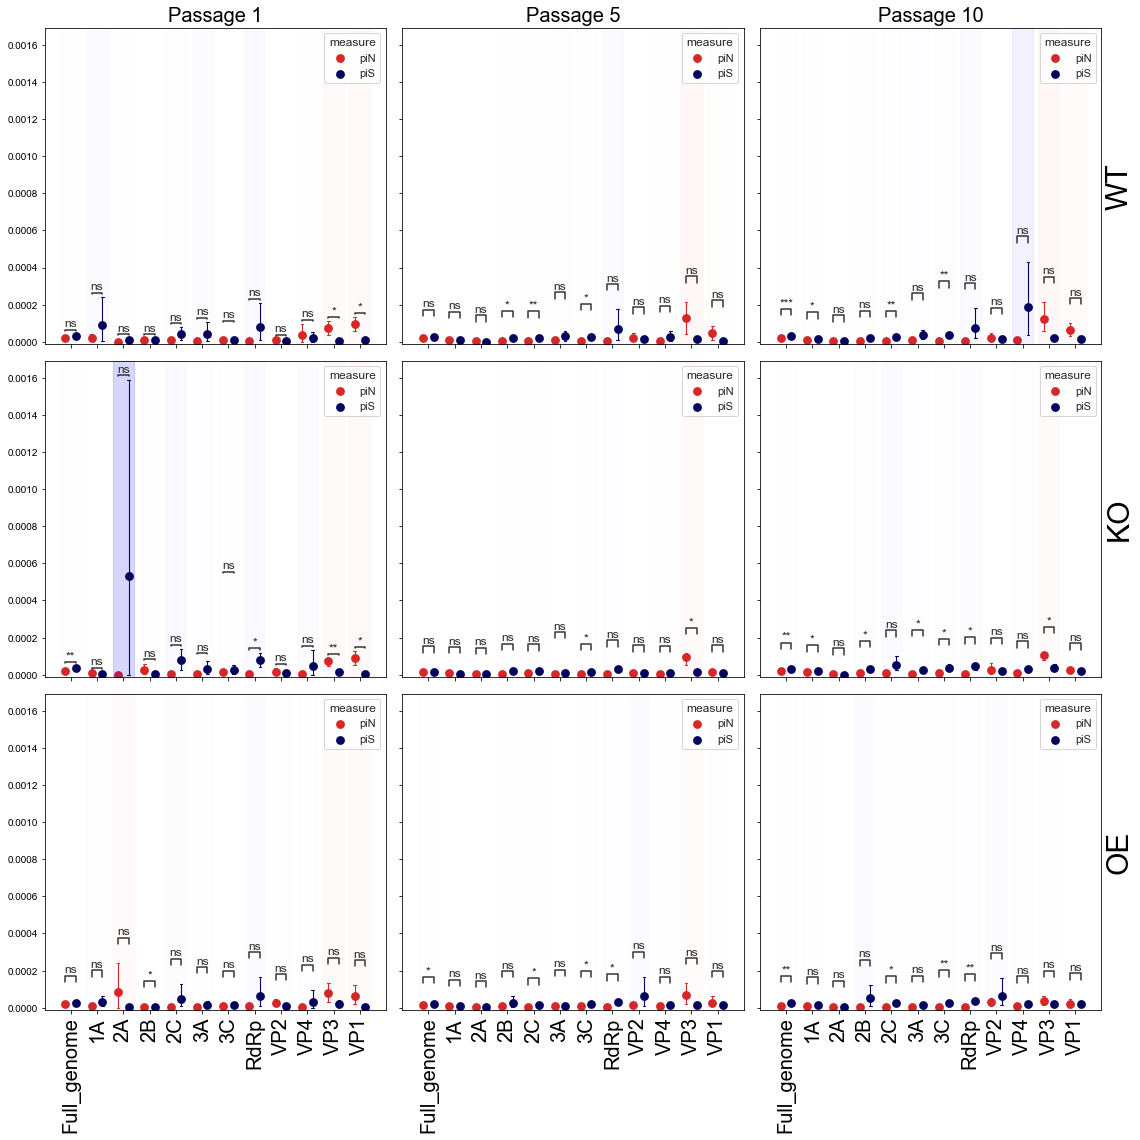

In [14]:
fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(16,16))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

for idx_passage, passage in enumerate(["passage_1", "passage_5", "passage_10"]):
    df_temp = df_sns[df_sns["passage"]==passage]
    for idx_genotype, genotype in enumerate(['wild_type', 'dicer_KO', 'dicer_over_expressing']):
        
        data = df_temp[df_temp["genotype"]==genotype]
        sns.pointplot(
            ax=ax[idx_genotype][idx_passage],
            data=data, 
            markers='o', 
            linestyles='',
            x="protein", 
            y='value', 
            hue ='measure', 
            errorbar=('ci', 95),
            hue_order=["piN", "piS"], 
            errwidth=1.1, 
            capsize=0.1,
            order=protein_order, 
            palette=['#d62828', '#03045e'],
            dodge=0.4, 
        )
        ax[idx_genotype][idx_passage].set_xlabel("")
        ax[idx_genotype][idx_passage].set_ylabel("")
        
        # shade background to show positive or negative selection
        df_direction_selection = df_p_value[df_p_value["passage"]==passage]
        df_direction_selection = df_direction_selection[df_direction_selection["genotype"]==genotype]
        
        for idx_protein, protein in enumerate(protein_order):  
            piN_minus_piS = df_direction_selection[df_direction_selection["protein"]==protein]["mean_piN-mean_piS"].values[0]
            if piN_minus_piS > 0: # positive selection 
                color = 'red'
                alpha = np.abs(piN_minus_piS)*300
            elif piN_minus_piS < 0: # negative selection 
                color='blue'
                alpha = np.abs(piN_minus_piS)*300
            
            ax[idx_genotype][idx_passage].axvspan(xmin=idx_protein-0.4, xmax=idx_protein+0.4, color=color, alpha=alpha)

        
        # subset the table otherwise the stats were calculated on the whole dataset
        annot = Annotator(ax[idx_genotype][idx_passage],
                          pairs_subplots, 
                          data=data, 
                          x="protein", 
                          y='value', 
                          order=protein_order,
                          hue='measure', 
                          hue_order=["piN", "piS"]) 
        annot.configure(test='t-test_paired',loc='inside', verbose=2)
        annot.apply_test().annotate()
        
        
ax[2][0].tick_params(axis='x', rotation=90, labelsize = 20)
ax[2][1].tick_params(axis='x', rotation=90, labelsize = 20)
ax[2][2].tick_params(axis='x', rotation=90, labelsize = 20)

ax[0][0].set_title("Passage 1", fontsize=20)
ax[0][1].set_title("Passage 5", fontsize=20)
ax[0][2].set_title("Passage 10", fontsize=20)

ax[0][2].set_ylabel("WT", fontsize=30)
ax[0][2].yaxis.set_label_position("right")
ax[1][2].set_ylabel("KO", fontsize=30)
ax[1][2].yaxis.set_label_position("right")
ax[2][2].set_ylabel("OE", fontsize=30)
ax[2][2].yaxis.set_label_position("right")

fig.tight_layout()
fig.show()

In [15]:
fig.savefig('./000__Manuscript_figures/Supplement_Figure_6__selection_analysis.pdf')
fig.savefig('./000__Manuscript_figures/Supplement_Figure_6__selection_analysis.svg')

In [16]:
"""
p-value annotation legend:  
      ns: p <= 1.00e+00  
       *: 1.00e-02 < p <= 5.00e-02  
      **: 1.00e-03 < p <= 1.00e-02  
     ***: 1.00e-04 < p <= 1.00e-03  
    ****: p <= 1.00e-04  
"""

'\np-value annotation legend:  \n      ns: p <= 1.00e+00  \n       *: 1.00e-02 < p <= 5.00e-02  \n      **: 1.00e-03 < p <= 1.00e-02  \n     ***: 1.00e-04 < p <= 1.00e-03  \n    ****: p <= 1.00e-04  \n'